In [1]:

import numpy as np
import plotly.graph_objects as go
import plotly.express as px


In [2]:
pmf = np.loadtxt("CA-umb/wham-0512-last60/pmf.dat")
rho = np.loadtxt("CA-umb/wham-0512-last60/rho.dat")
bia = np.loadtxt("CA-umb/wham-0512-last60/bia.dat")

rows = np.unique(pmf[:,0]);
cols = np.unique(pmf[:,1]);

pmf[np.where(pmf[:,2]==np.inf),2]=0;

pmf_array = np.zeros((len(rows),len(cols)));
rho_array = np.zeros((len(rows),len(cols)));
bia_array = np.zeros((len(rows),len(cols)));

for i, angle in enumerate(rows):
    for j, dist in enumerate(cols):
            l = np.intersect1d(np.where(pmf[:,0] == angle), np.where(pmf[:,1] == dist));
            if (l.size > 0):
                pmf_array[i,j] = pmf[l[0],2]
                bia_array[i,j] = bia[l[0],2]
                rho_array[i,j] = rho[l[0],2]
                
mature=(len(rows)-5,9)
immature=(4,len(cols)-5)

pmf_min = np.min(pmf_array[7:-5,2:-2]);
pmf_array -= pmf_min;
pmf[:,2] -= pmf_min;

implementation of Djikstra's algorithm to find initial MFEP (unused)

In [3]:
def checkNodes(origin,dest,dist,path,unvisited,pmf):
    # find unvisited nodes adjacent to minimum distance node
    adj = np.zeros((0,2));
    i,j=np.unravel_index(np.argmin(dist + 1000*(1-unvisited)),dist.shape)
    adjNewCand = np.array(np.meshgrid(range(i-1,i+2),range(j-1,j+2))).reshape(2,-1).T;
    # make sure they are inbounds
    adjNewCand = adjNewCand[np.where(adjNewCand[:,0] >= 0),:][0];
    adjNewCand = adjNewCand[np.where(adjNewCand[:,1] >= 0),:][0];
    adjNewCand = adjNewCand[np.where(adjNewCand[:,0] < dist.shape[0]),:][0];
    adjNewCand = adjNewCand[np.where(adjNewCand[:,1] < dist.shape[1]),:][0];

    # check if visited
    for idx in adjNewCand:
        if unvisited[idx[0],idx[1]]:
            adj = np.vstack((adj, idx));
    # only one instance of each node
    adj = np.unique(adj,axis=0);
    
    # set distance at each node
    for ij in adj:
        inew,jnew=int(ij[0]),int(ij[1]);
        # set distance based on current node
        if dist[inew,jnew]>dist[i,j] + np.abs(pmf[inew,jnew]-pmf[i,j]):
            dist[inew,jnew] = dist[i,j] + np.abs(pmf[inew,jnew]-pmf[i,j]);
            path[inew,jnew] = np.ravel_multi_index((i,j),dist.shape);
    
    unvisited[i,j] = 0;
    
    return path, dist, unvisited;

In [4]:
dist = 1000*np.ones(pmf_array.shape);
dist[immature]=0;
unvisited=np.ones(pmf_array.shape);
path_all=np.zeros(pmf_array.shape,dtype=int);
while (np.max(unvisited) == 1):
    path_all,dist,unvisited = checkNodes(immature,mature,dist,path_all,unvisited,pmf_array)

In [5]:
#patharg = np.zeros((0,1),dtype=int);
ij = np.ravel_multi_index(mature,dist.shape);
patharg = ij;
while ij != np.ravel_multi_index(immature,dist.shape):
    patharg =np.vstack((patharg,path_all[np.unravel_index(ij,dist.shape)]));
    ij = path_all[np.unravel_index(ij,dist.shape)];

In [6]:
path = np.zeros((len(patharg),2))
for i,p in enumerate(patharg):
    p_ij = np.unravel_index(p,dist.shape);
    path[i] = [cols[p_ij[1][0]],rows[p_ij[0][0]]]

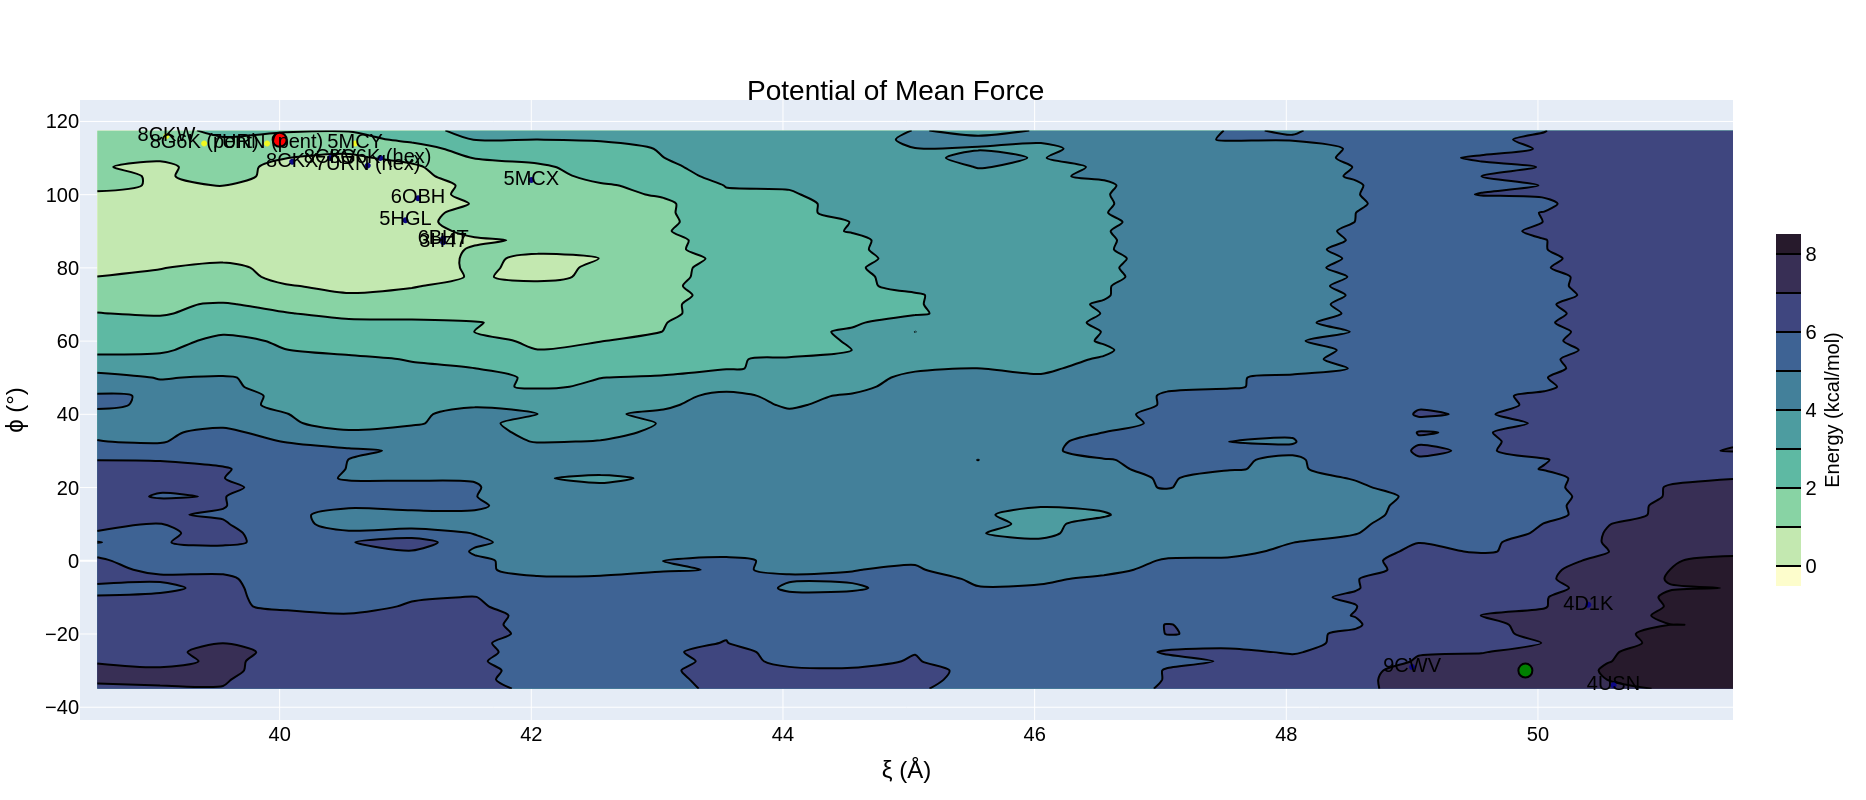

In [7]:

fig = go.Figure( \
    data = go.Contour( \
        z=pmf_array[7:-5,2:-2],
        x=cols[2:-2], y=rows[7:-5],
        line_smoothing=0.8,
        line_width=2,
         contours=dict(
            start=0,
            end=8,
            size=1),
                      colorscale='deep',
                      colorbar=dict(
            title='Energy\n(kcal/mol)', # title here
            titleside='right',
            titlefont=dict(
                size=20,
                family='Arial, sans-serif',
            color='black'),
            thickness=25,
            thicknessmode='pixels',
            len=0.6,
            lenmode='fraction',
            outlinewidth=0)));
fig.update_layout(
    title={
        'text': "Potential of Mean Force",
        'y':0.9,
        'x':0.48,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="ξ (Å)",
    yaxis_title="ϕ (°)",
    font=dict(size=20,family='Arial',color='black'),
    showlegend=False
)
fig['layout'].update(width=800,height=800)
fig.add_trace(go.Scatter(x=[40.0,49.9], y=[115,-30],
                    mode='markers',marker=dict(
            color=['red','green'], 
            size=14,
            line=dict(
                color='black',
                width=2
            )
        )))
#fig.add_trace(go.Scatter(x=path[:,0], y=path[:,1],
#                    mode='lines', line_shape='spline', line=dict(
#                color='black',
#                width=2
#            )
#        ))
#fig.add_trace(go.Scatter(x=[41.9,42.1,40.9,42.4,50.6,43.2,42.8,51.2],
#                        y=[104,102,108,104,-29,90,99,-30],
#                        mode='markers+text',marker=dict(color='black',size=14,symbol="x"),
#                        text=['8G6K','8CKX','8CKW','8CKV','7ASL','6OBH','5MCX','4D1K'],
#                        textposition='middle left'))

x_array = [40.8,39.4,40.1,39.1,40.4,49.0,41.1,42.0,50.4,41.3,41.0,50.6,41.3,40.6,39.9,40.7]
y_array = [110,114,109,116,110,-29,99,104,-12,87,93,-34,88,114,114,108]
pdb_array = ['8G6K (hex)','8G6K (pent)','8CKX','8CKW','8CKV','9CWV','6OBH','5MCX', \
             '4D1K','3H47','5HGL','4USN','6BHT','5MCY','7URN (pent)','7URN (hex)']
pent_array = [0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0]
fig.add_trace(go.Scatter(x=x_array,y=y_array,mode='markers+text',text=pdb_array, \
                         marker=dict(color=pent_array)))

#for i in range(len(x_array)):
#    fig.add_annotation(x=x_array[i], y=y_array[i],
#                text=pdb_array[i],
#                showarrow=True,
#                arrowhead=3,yshift=0)

#fig.update_annotations(font=dict(family='Arial, sans-serif',size=16))

fig.show()
#fig.write_image('pmf.svg')

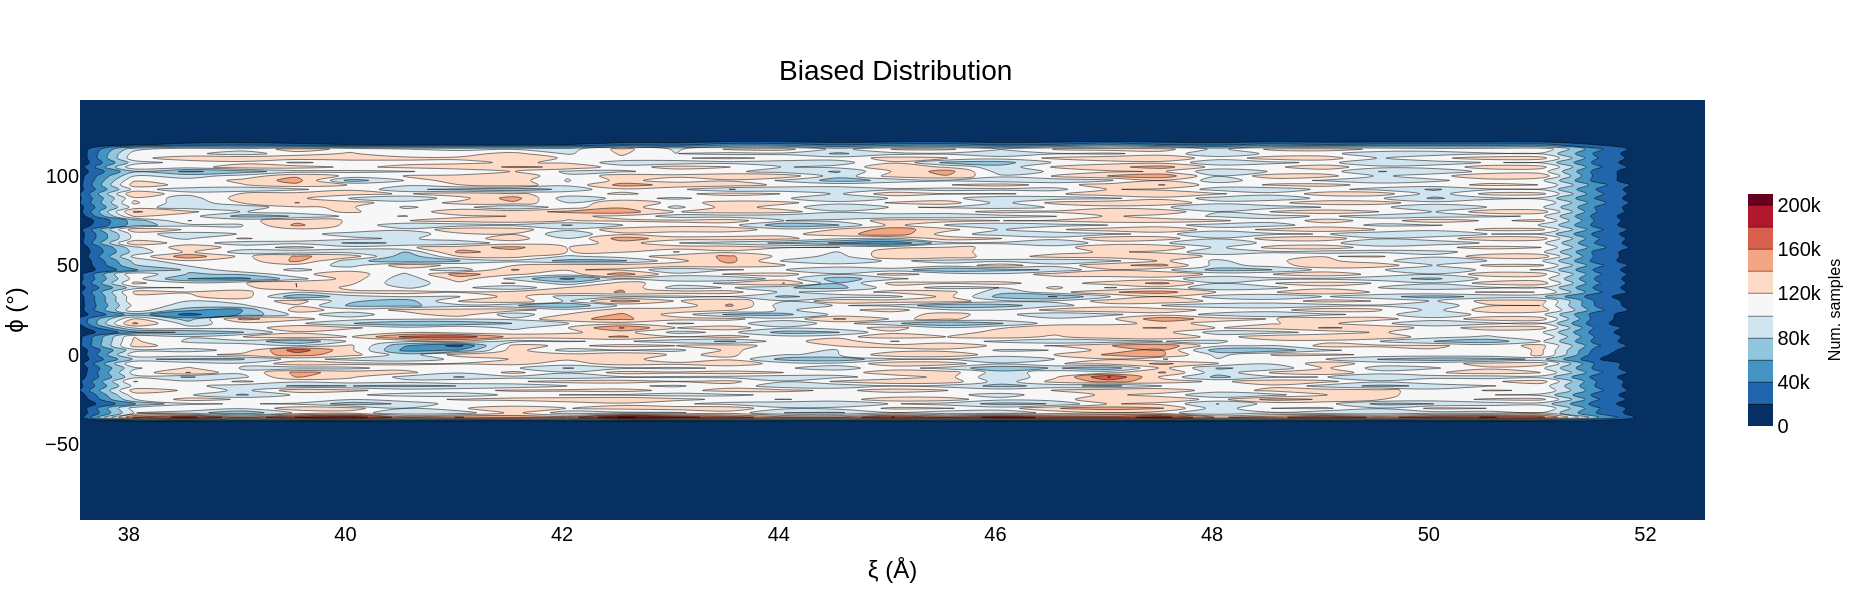

In [52]:

fig = go.Figure( \
    data = go.Contour( \
        z=bia_array,
        x=cols, y=rows,
                #     contours=dict(
            #start=0,
            #end=15,
            #size=1),
                      colorscale='RdBu',
                      reversescale=True,
                      colorbar=dict(
            title='Num. samples', # title here
            titleside='right',
            titlefont=dict(
                size=16,
                family='Arial, sans-serif',
            color='black'),
            thickness=25,
            thicknessmode='pixels',
            len=0.6,
            lenmode='fraction',
            outlinewidth=0)));
fig.update_layout(
    title={
        'text': "Biased Distribution",
        'y':0.9,
        'x':0.48,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="ξ (Å)",
    yaxis_title="ϕ (°)",
    font=dict(size=20,family='Arial',color='black'),
    showlegend=False
)
fig['layout'].update(width=700,height=600)
fig.show()

String method to find MFEP using Gaussian process regression and gradient descent

In [8]:
# rescale PMF
pmf_norm = pmf.copy();
pmf_norm[:,0] = (pmf[:,0] + 30)/(110 + 30); # immature to 0, mature to 1
pmf_norm[:,1] = (pmf[:,1] - 49.8)/(40.2 - 49.8);

# only train using nonzero PMFs
pmf_norm = pmf_norm[np.where(pmf_norm[:,2]>0)];

path_norm = path.copy();
path_norm[:,0] = (path[:,0] - 49.8)/(40.2 - 49.8)
path_norm[:,1] = (path[:,1] + 30)/(110 + 30)
path_norm = np.vstack((path_norm,[0,0]))

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic

kernel = 1.0 * RationalQuadratic(length_scale=1,alpha=0.01)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0, n_restarts_optimizer=9)

gpr.fit(pmf_norm[:,:2],pmf_norm[:,2])

colvars_tl = np.meshgrid(np.arange(-0.1,1.1,0.1),np.arange(-0.1,1.1,0.1));
colvars_test = np.array([c.flatten() for c in colvars_tl])
pmf_test = gpr.predict(colvars_test.T)

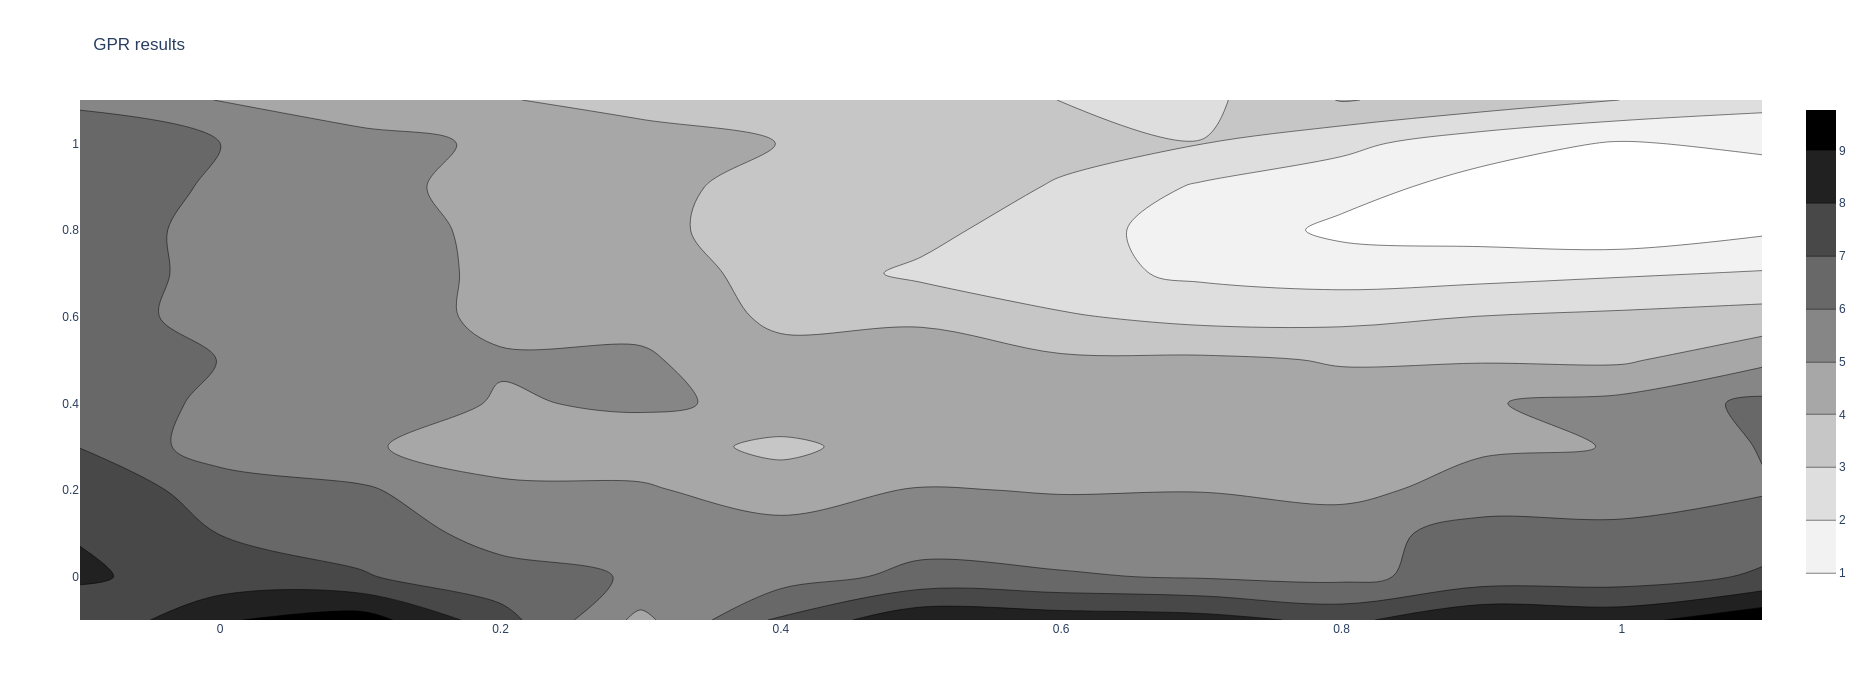

In [10]:
fig = go.Figure( \
    data = go.Contour( \
        z=pmf_test.reshape(colvars_tl[0].shape).T,
        y=np.arange(-0.1,1.1,0.1), x=np.arange(-0.1,1.1,0.1), colorscale="Greys"));
fig.update_layout(title='GPR results', autosize=False,height=700,width=700)
fig.show()

In [11]:
gpr.kernel_

9.43**2 * RationalQuadratic(alpha=0.00118, length_scale=0.432)

In [12]:
def gprFD(gpr,X,dX):
    # use symmetric first-order finite difference
    grad = X.copy();
    for i in range(X.shape[1]):
        Xfw = X.copy();
        Xfw[:,i] = X[:,i] + dX[:,i];
        Xbck = X.copy();
        Xbck[:,i] = X[:,i] - dX[:,i];
        grad[:,i] = (gpr.predict(np.flip(Xfw)) - gpr.predict(np.flip(Xbck)))/(2*dX[:,i])
    return grad

In [13]:
path_grad = np.array([gprFD(gpr,np.array(path_norm[i]).reshape(1,-1),np.array([0.01,0.01]).reshape(1,-1)) for i in range(len(path_norm))])

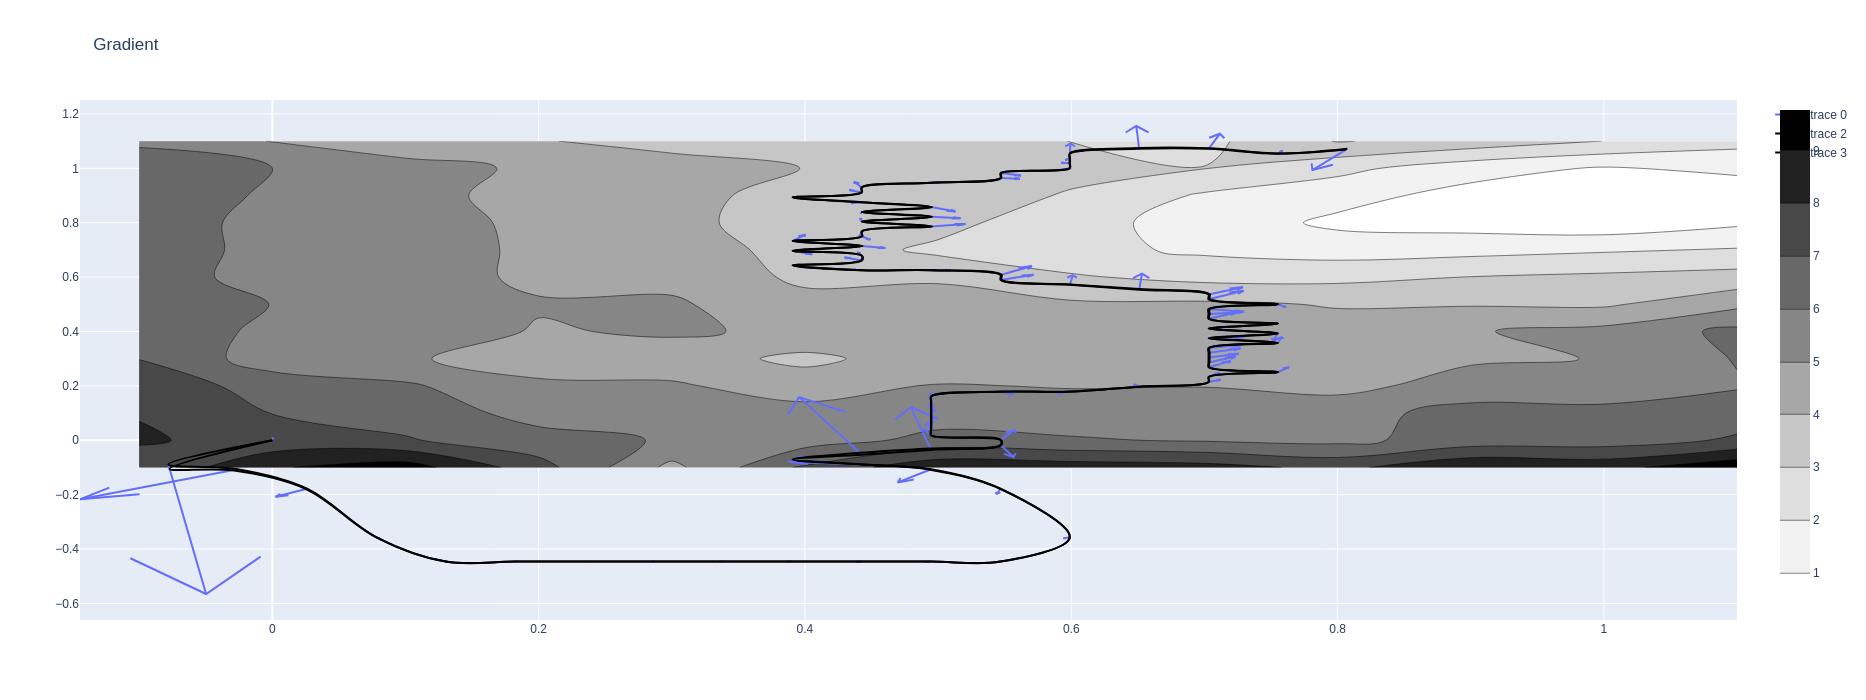

In [14]:
from plotly.figure_factory import create_quiver

fig = create_quiver(x=path_norm[:,0],y=path_norm[:,1],u=-0.03*path_grad[:,:,0],v=-0.03*path_grad[:,:,1])
fig.add_trace(go.Contour( \
        z=pmf_test.reshape(colvars_tl[0].shape).T, y=np.arange(-0.1,1.1,0.1), x=np.arange(-0.1,1.1,0.1), colorscale="Greys"));
fig.add_trace(go.Scatter(x=path_norm[:,0], y=path_norm[:,1],
                    mode='lines', line_shape='spline', line=dict(
                color='black',
               width=2
            )
        ))
A=0.0001;
fig.add_trace(go.Scatter(x=path_norm[:,0]-A*path_grad[:,:,0].reshape(-1), y=path_norm[:,1]-A*path_grad[:,:,1].reshape(-1),
                    mode='lines', line_shape='spline', line=dict(
                color='black',
                width=2
            )
        ))
fig.update_layout(title='Gradient', autosize=False,height=700,width=700)

fig.show()

In [15]:
dists = np.cumsum([np.sqrt(l[0]**2 + (l[1])**2) for l in (path_norm[1:] - path_norm[:-1])])
dists = np.append([0],dists)

In [16]:
# don't move beginning and end points
path_new = path_norm.copy()
path_new[1:-1] = path_norm[1:-1] - A*path_grad.reshape(-1,2)[1:-1]

dists = np.cumsum([np.sqrt(l[0]**2 + l[1]**2) for l in (path_new[1:] - path_new[:-1])])
dists = np.append([0],dists)

even_dists = np.linspace(dists[0],dists[-1],20)
even_path = np.zeros((len(even_dists),2))
for i, d in enumerate(even_dists[:-1]):
    loc = np.where(dists > d)[0][0] - 1;
    even_path[i,0] = np.interp(d,dists[loc:(loc+2)],path_new[loc:(loc+2),0])
    even_path[i,1] = np.interp(d,dists[loc:(loc+2)],path_new[loc:(loc+2),1])

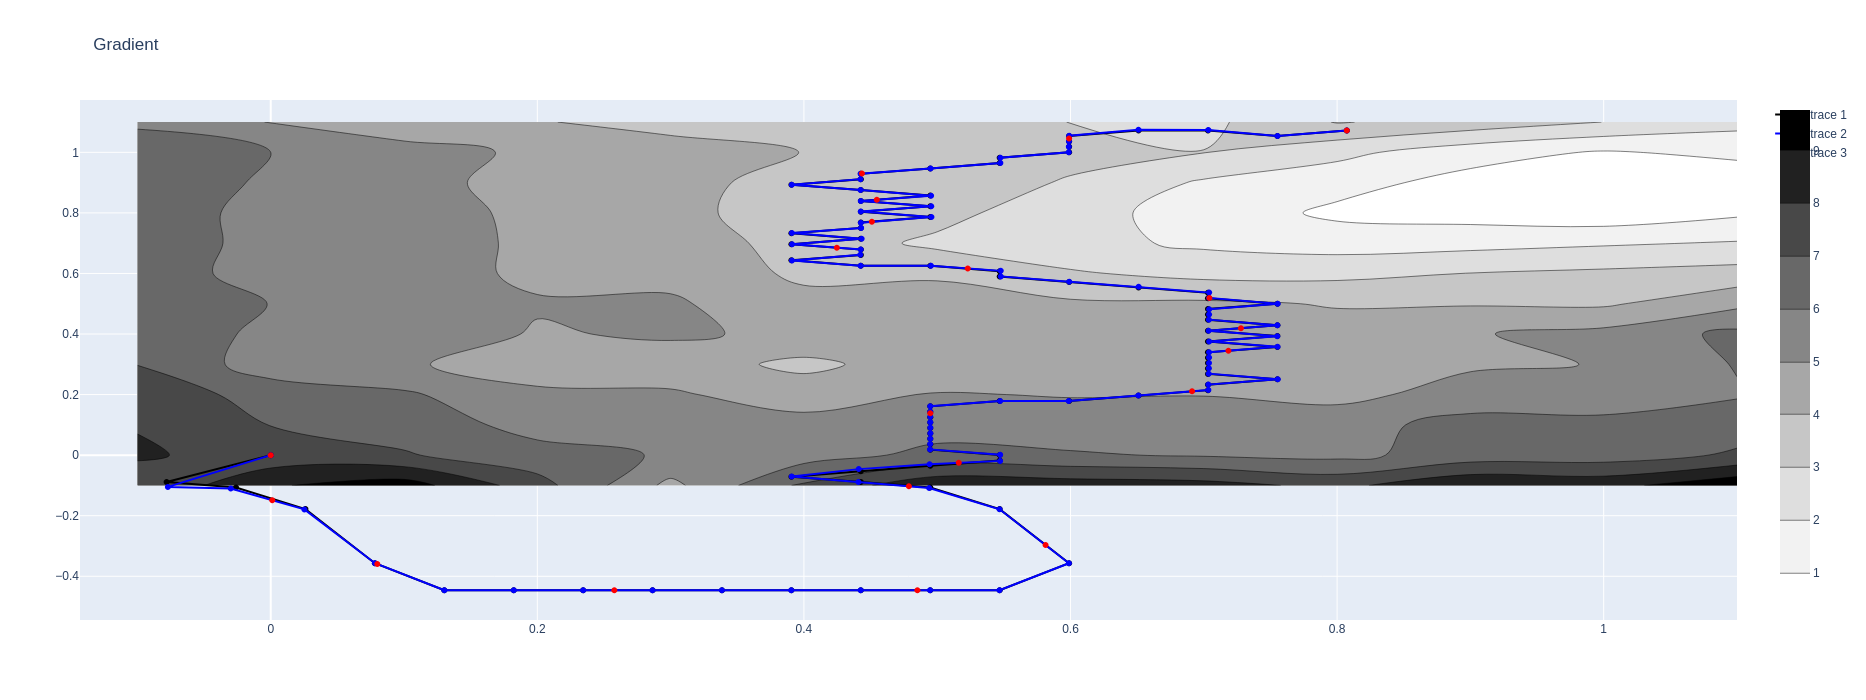

In [17]:
fig = go.Figure(data = go.Contour( \
        z=pmf_test.reshape(colvars_tl[0].shape).T, y=np.arange(-0.1,1.1,0.1), x=np.arange(-0.1,1.1,0.1), colorscale="Greys"));
fig.add_trace(go.Scatter(x=path_norm[:,0], y=path_norm[:,1],
                    mode='markers+lines', line_shape='linear', line=dict(
                color='black',
               width=2
            )
        ))
A=0.005;
fig.add_trace(go.Scatter(x=path_new[:,0], y=path_new[:,1],
                    mode='markers+lines', line_shape='linear', line=dict(
                color='blue',
                width=2
            ), marker=dict(color='blue')
        ))
fig.add_trace(go.Scatter(x=even_path[:,0],y=even_path[:,1],mode='markers',marker=dict(color='red')))
fig.update_layout(title='Gradient', autosize=False,height=700,width=700)
fig.show()

In [18]:
num_iter = 100
A = 0.001;
n=32
dX = np.array([0.01,0.01]).reshape(1,-1);
# rescale PMF
pmf_norm = pmf.copy();
pmf_norm[:,0] = (pmf[:,0] + 30)/(110 + 30); # immature to 0, mature to 1
pmf_norm[:,1] = (pmf[:,1] - 49.8)/(40.2 - 49.8);


# linear path
path_norm = np.zeros((n,2));
path_norm[:,0] = np.linspace(1,0,n);
path_norm[:,1] = np.linspace(1,0,n);

pathAll = [path_norm];

for j in range(num_iter):
    # find gradient at each point on path
    path_grad = np.array([gprFD(gpr,np.array(path_norm[i]).reshape(1,-1),dX) for i in range(len(path_norm))])

    # move each point along gradient
    # don't move beginning and end points
    path_new = path_norm.copy()
    path_new[1:-1] = path_norm[1:-1] - A*path_grad.reshape(-1,2)[1:-1]

    # reparametrize by length
    dists = np.cumsum([np.sqrt(l[0]**2 + l[1]**2) for l in (path_new[1:] - path_new[:-1])])
    dists = np.append([0],dists)

    even_dists = np.linspace(dists[0],dists[-1],n)
    even_path = np.zeros((len(even_dists),2))
    for i, d in enumerate(even_dists[:-1]):
        loc = np.where(dists > d)[0][0] - 1;
        even_path[i,0] = np.interp(d,dists[loc:(loc+2)],path_new[loc:(loc+2),0])
        even_path[i,1] = np.interp(d,dists[loc:(loc+2)],path_new[loc:(loc+2),1])
        
    # calculate error
    err = 0;
    for i in range(len(even_path)-1):
        err += np.sqrt(np.sum((even_path[i] -path_norm[i])**2))
    print(err);
    
    if err < 0.01:
        break;
        
    path_norm = even_path;
    pathAll += [even_path];

0.19707156092524544
0.20250340908415707
0.1394734353046359
0.16815421922042056
0.1107149762533187
0.07631470776716777
0.06418091532915941
0.05529934657039193
0.057272879659818976
0.06725664019865332
0.06629247348186884
0.05240688038168119
0.036887102962541427
0.0318528123934392
0.029597018429725196
0.025100146754807626
0.01995096610855999
0.02044586391646917
0.020662234671582576
0.018301329494096165
0.015766466502562346
0.015840509930501966
0.01856788565728102
0.024093385236423338
0.030249406866326104
0.03641479086709278
0.044417232429909255
0.056739860445997624
0.056939407866747525
0.040173093367924725
0.036071831196830835
0.038732729781626875
0.03584161292620145
0.030768283114083573
0.040288653971539905
0.08253459509765529
0.08914701669218647
0.05183267262596048
0.04975397348239094
0.0454073897444439
0.04365453171992985
0.041908163991338704
0.02933796850422945
0.02335514178258474
0.02988515250137729
0.03433249603678794
0.0463706970834109
0.0577726966617484
0.05353599702559747
0.03493

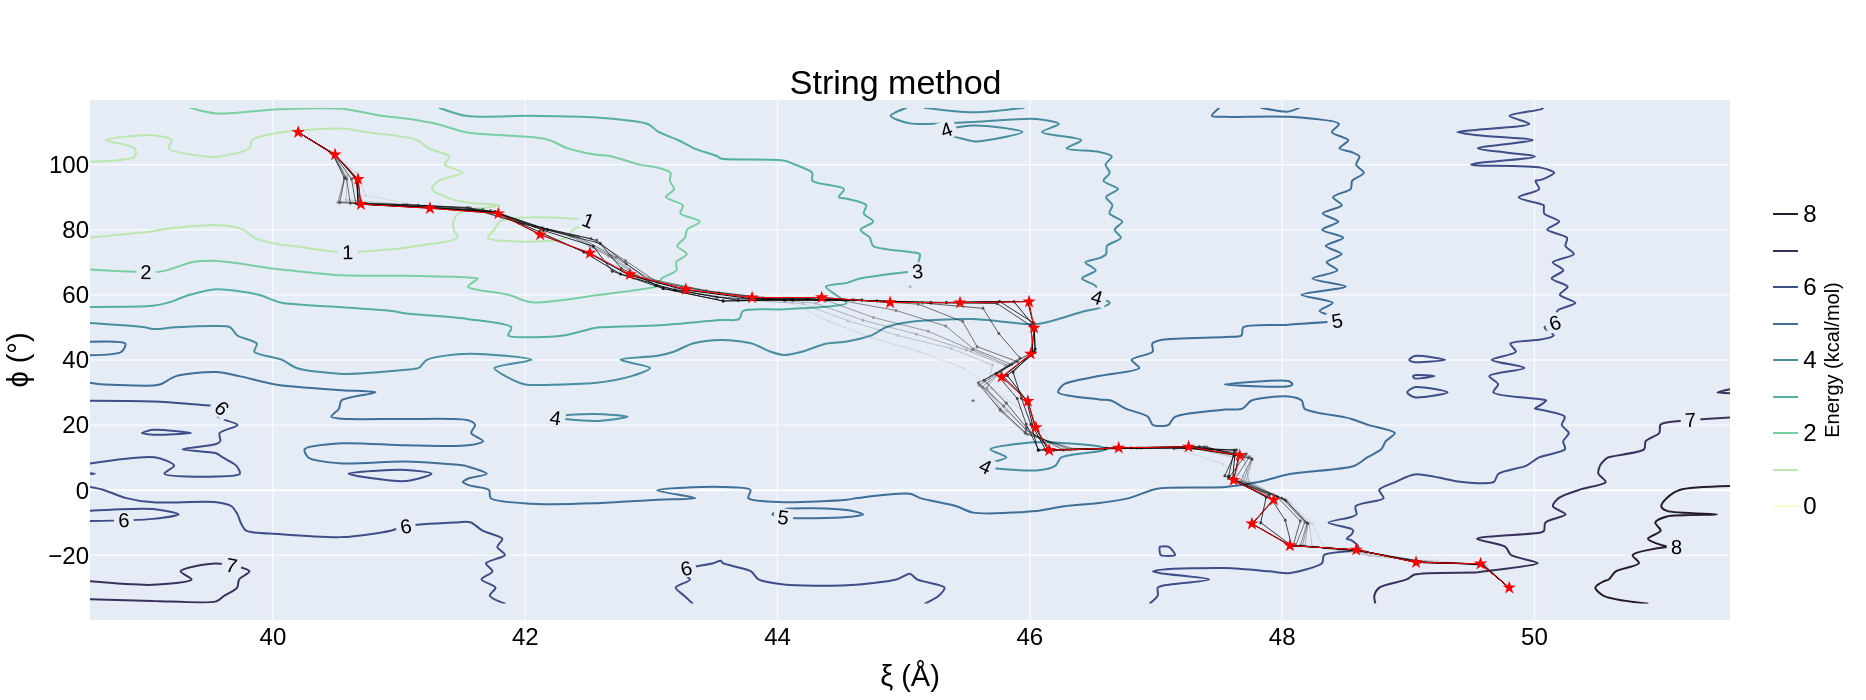

In [19]:
fig = go.Figure( \
    data = go.Contour( \
        z=pmf_array[7:-5,2:-2],
        x=cols[2:-2], y=rows[7:-5],
        line_smoothing=0.8,
         contours=dict(
            start=0,
            end=8,
            size=1,
                    showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 20,
                color = 'black',
                family='Arial, sans-serif'
)),
            contours_coloring='lines',
        line_width=2,
                      colorscale='deep',
                      reversescale=False,
                      colorbar=dict(
            title='Energy\n(kcal/mol)', # title here
            titleside='right',
            titlefont=dict(
                size=20,
                family='Arial, sans-serif',
            color='black'),
            thickness=25,
            thicknessmode='pixels',
            len=0.6,
            lenmode='fraction',
            outlinewidth=0)));
fig.update_coloraxes(showscale=False)

pathAll = np.array(pathAll[1:])

path_linear_tf = pathAll.copy();
path_linear_tf[:,:,0] = (40.2 - 49.8)*pathAll[:,:,0] + 49.8
path_linear_tf[:,:,1] = (110 + 30)*pathAll[:,:,1] - 30

for i, p in enumerate(path_linear_tf):
    if (i % 5 == 0):
        c=int(255-np.floor(255*i/len(pathAll)))
        fig.add_trace(go.Scatter(x=p[:,0], y=p[:,1],
                            mode='markers+lines', line_shape='linear', marker_size=3,\
                                 line=dict(width=1,color='black'),name='iteration %d' % i,opacity=i/len(path_linear_tf)))

fig.add_trace(go.Scatter(x=path_linear_tf[-1,:,0], y=path_linear_tf[-1,:,1],
                    mode='markers+lines', line_shape='linear', \
                         line=dict(width=1,color='red'),marker_symbol='star',marker_size=10))
fig.update_layout(
    title={
        'text': "String method",
        'y':0.9,
        'x':0.48,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="ξ (Å)",
    yaxis_title="ϕ (°)",
    font=dict(size=24,family='Arial',color='black'),
    showlegend=False, height=700,width=700
)
fig.show()
#fig.write_image('string.svg')

In [20]:
path_linear = pathAll[-1];

In [21]:
phi = np.arange(-35,115,5)
xi = np.array([39.5,40.2,40.9,41.6,42.3,42.9,43.6,44.3,45.0,45.7,46.4,47.1,47.7,48.4,49.1,49.8,50.5])

colvar_rate = 100
dcd_rate = 20000
ratio = dcd_rate//colvar_rate # integer ratio of sampling rates

path_linear_tf = path_linear.copy();
path_linear_tf[:,0] = (40.2 - 49.8)*path_linear[:,0] + 49.8
path_linear_tf[:,1] = (110 + 30)*path_linear[:,1] - 30



In [22]:
fAll = open("CA_path_images_0813_fixed.txt","w");

for i, p in enumerate(path_linear_tf):
    nearest = [phi[np.argmin(np.abs(p[1]-phi))], xi[np.argmin(np.abs(p[0]-xi))]];
    dat=np.loadtxt("CA-umb/umb-010525/output/%02d.0-%.1f/%02d.0-%.1f.colvars.traj"%(nearest[0],nearest[1],nearest[0],nearest[1]))
    dat_dcd = dat[::ratio]
    step = dat_dcd[np.argsort((p[1]-dat_dcd[:,2])**2+(p[0]-dat_dcd[:,1])**2)[:10],0]
    fAll.write("CA-umb/umb-010525/output/%02d.0-%.1f/%02d.0-%.1f.dcd, %d\n" % (nearest[0],nearest[1],nearest[0],nearest[1],step[0]//dcd_rate))
    f = open("CA_path_top10_%d.txt" % i, "w");
    for s in step:
        f.write("CA-umb/umb-010525/output/%02d.0-%.1f/%02d.0-%.1f.dcd, %d\n" % (nearest[0],nearest[1],nearest[0],nearest[1],s//dcd_rate))
    f.close()
fAll.close()

In [24]:
phi = np.unique(pmf[:,0])
xi = np.unique(pmf[:,1])

pmf_path = []
for p in path_linear_tf:
    nearest = [phi[np.argmin(np.abs(p[1]-phi))], xi[np.argmin(np.abs(p[0]-xi))]];
    l = np.intersect1d(np.where(pmf[:,0] == nearest[0]), np.where(pmf[:,1] == nearest[1]));
    pmf_path = pmf_path + [pmf[l,2]];

In [25]:
nb=6
pmf_blocks = []
for i in range(nb):
    pmf_blocks += [np.loadtxt('CA-umb/wham-0126-blocks/pmf-%d.dat' % (i+9-nb))]


In [26]:
pmf_var_path = []
pmf_mean_path = []
for p in path_linear_tf:
    nearest = [phi[np.argmin(np.abs(p[1]-phi))], xi[np.argmin(np.abs(p[0]-xi))]];
    l = np.intersect1d(np.where(pmf_blocks[0][:,0] == nearest[0]), np.where(pmf_blocks[0][:,1] == nearest[1]));
    pmf_mean_path = pmf_mean_path + [np.mean([pmf_blocks[_][l,2] for _ in range(len(pmf_blocks))])];
    pmf_var_path = pmf_var_path + [np.var([pmf_blocks[_][l,2] for _ in range(len(pmf_blocks))])];

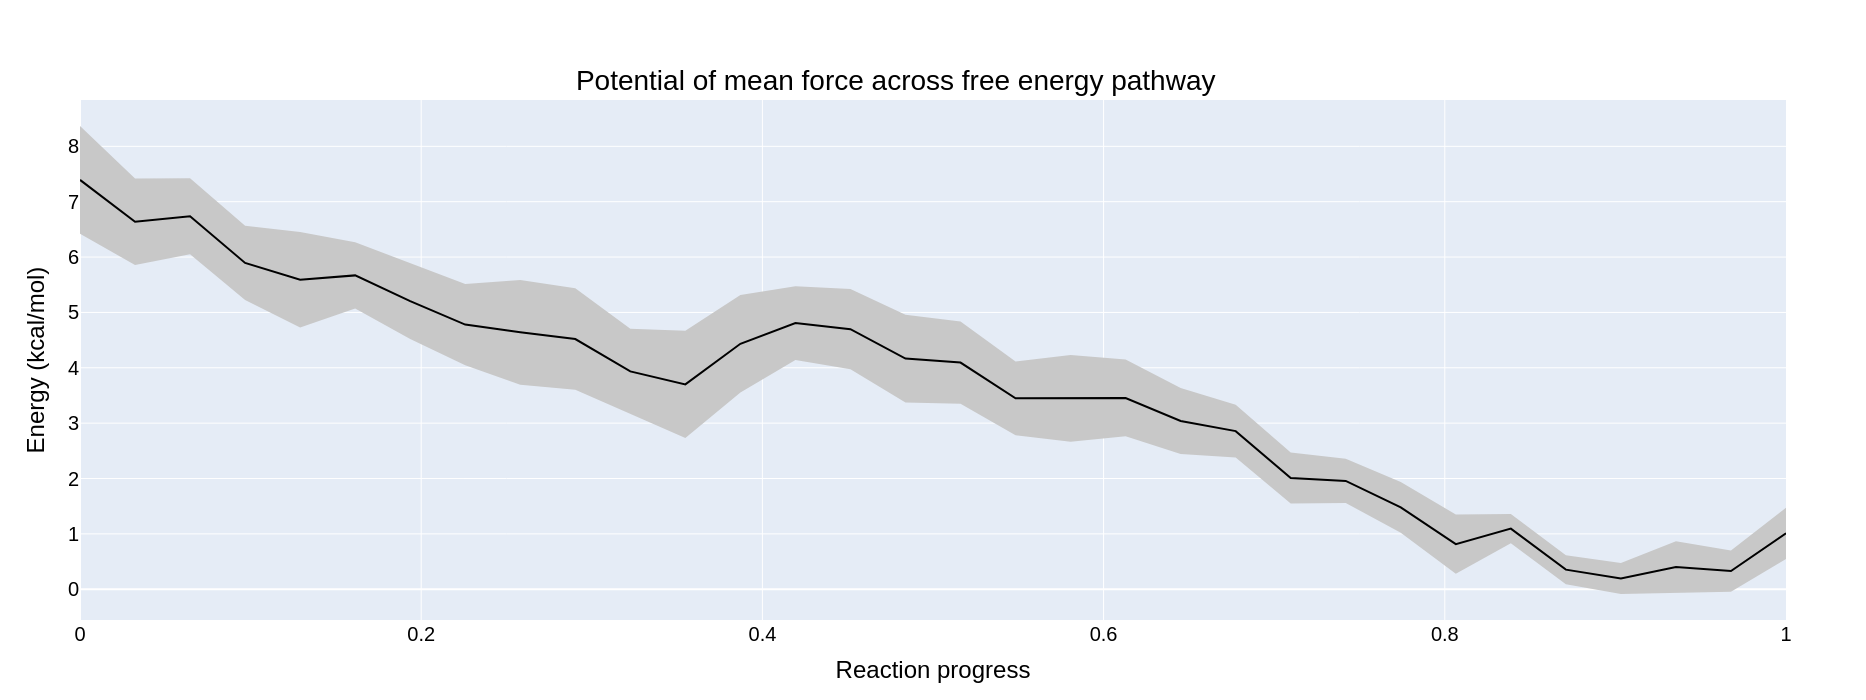

In [28]:
fig = go.Figure()
ln='linear'
cl='black'

y_upper = np.array(pmf_path).reshape(-1)+np.sqrt(np.array(pmf_var_path)).reshape(-1)
y_lower = np.array(pmf_path).reshape(-1)-np.sqrt(np.array(pmf_var_path)).reshape(-1)
y_fill = np.append(y_upper,y_lower[::-1])
x_fill = np.append(np.linspace(1,0,len(pmf_path)),np.linspace(0,1,len(pmf_path)))
fig.add_trace(go.Scatter(x=x_fill, y=y_fill, fill='toself', fillcolor='rgba(200,200,200,1)',line_shape=ln,line_color='rgba(255,255,255,0)',showlegend=False)) 
fig.add_trace(go.Scatter(x=np.linspace(1,0,len(pmf_path)), y=np.array(pmf_path).reshape(-1),line_shape=ln, line=dict(color=cl),showlegend=False)) 

fig.update_layout(
    title={
        'text': "Potential of mean force across free energy pathway",
        'y':0.9,
        'x':0.48,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Reaction progress",
    yaxis_title="Energy (kcal/mol)",
    font=dict(size=20,family='Arial',color='black'),
    height=700,width=700
)
#fig.write_image('pmf_1d.svg')
fig.show()